In [112]:
STUDENTDATAFILE = 'creditos_banco_alumnos.csv'
EVALDATAFILE    = 'creditos_banco_evaluacion.csv'
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np


In [113]:
df = pd.read_csv(STUDENTDATAFILE)
df.head()

,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,2000,3,37000,6.29,2.22551,9663,96.6,Deuda,Hipoteca,0,0,2,4.4,paid off,2
1,28625,5,64000,15.34,14.07690,20084,60.3,Deuda renovable,Hipoteca,0,0,18,3.8,paid off,3
2,10400,3,76000,15.11,5.71753,4808,40.1,Deuda,Alquiler,0,1,8,4.4,paid off,7
3,33425,5,75000,20.85,14.08580,25807,60.7,Deuda,Hipoteca,0,1,14,4.0,paid off,11
4,15000,5,55000,7.66,9.43025,8452,49.4,Deuda,Alquiler,1,1,10,1.4,default,4


# Etapa de preprocesamiento #
1. Verificamos valores nulos
2. Verificamos valores únicos
3. Utilizamos boxplot para encontrar posibles outliers
4. Eliminar outliers

#### Verificamos valores nulos

In [115]:
#Verificamos valores nulos
print(df.isnull().sum()/len(df)*100)
# No se encontraron valores nulos en las columnas, por lo tanto no imputamos

Importe                 0.0
añosPago                0.0
IngresoAnuales          0.0
RelacionIngresoDeuda    0.0
RelacionCuotaDeuda      0.0
PendienteEnTarjeta      0.0
UsoCreditoTarjeta       0.0
Objetivo                0.0
esPropietario           0.0
FueVeraz                0.0
TuvoEmbargo             0.0
Cuentas                 0.0
PuntuacionGeneral       0.0
Default                 0.0
AntiguedadLaboral       0.0
dtype: float64


#### Verificamos valores únicos

In [116]:

# Resumen de estadísticas
print("\nResumen de estadísticas numéricas:")
print(df.describe())
print("\nResumen de estadísticas categóricas:")
print(df.describe(include=['object']))

#Pasamos a numéricas


Resumen de estadísticas numéricas:
            Importe      añosPago  IngresoAnuales  RelacionIngresoDeuda  \
count  34006.000000  34006.000000    3.400600e+04          34006.000000   
mean   13172.604099      3.503441    6.813686e+04             16.110743   
std     8101.327372      0.868015    4.549577e+04              7.593360   
min      500.000000      3.000000    3.500000e+03              0.000000   
25%     7000.000000      3.000000    4.200000e+04             10.460000   
50%    11500.000000      3.000000    6.000000e+04             16.010000   
75%    18000.000000      5.000000    8.200000e+04             21.560000   
max    35000.000000      5.000000    1.200000e+06             38.600000   

       RelacionCuotaDeuda  PendienteEnTarjeta  UsoCreditoTarjeta  \
count        34006.000000        3.400600e+04       34006.000000   
mean             8.026282        1.497325e+04          56.087961   
std              4.267497        2.108654e+04          25.437684   
min             

#### Convertimos a numéricos las columnas:
Tratamientos a realizar en cada columna Label encoding ya que unicamente puede tomar un tipo de valor
1. Objetivo
2. Default
3. EsPropietario

In [117]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Inicializamos los codificadores
label_encoder_objetivo = LabelEncoder()
label_encoder_default = LabelEncoder()
label_encoder_propietario = LabelEncoder()

# Codificamos y actualizamos la columna 'Objetivo'
df['Objetivo'] = label_encoder_objetivo.fit_transform(df['Objetivo'])

# Codificamos y actualizamos la columna 'default'
df['Default'] = label_encoder_default.fit_transform(df['Default'])

# Codificamos y actualizamos la columna 'esPropietario'
df['esPropietario'] = label_encoder_propietario.fit_transform(df['esPropietario'])

print(df[['Objetivo', 'Default', 'esPropietario']].head())



   Objetivo  Default  esPropietario
0         2        1              1
1         3        1              1
2         2        1              0
3         2        1              1
4         2        0              0


#### Analizamos posibles outliers con Boxplot

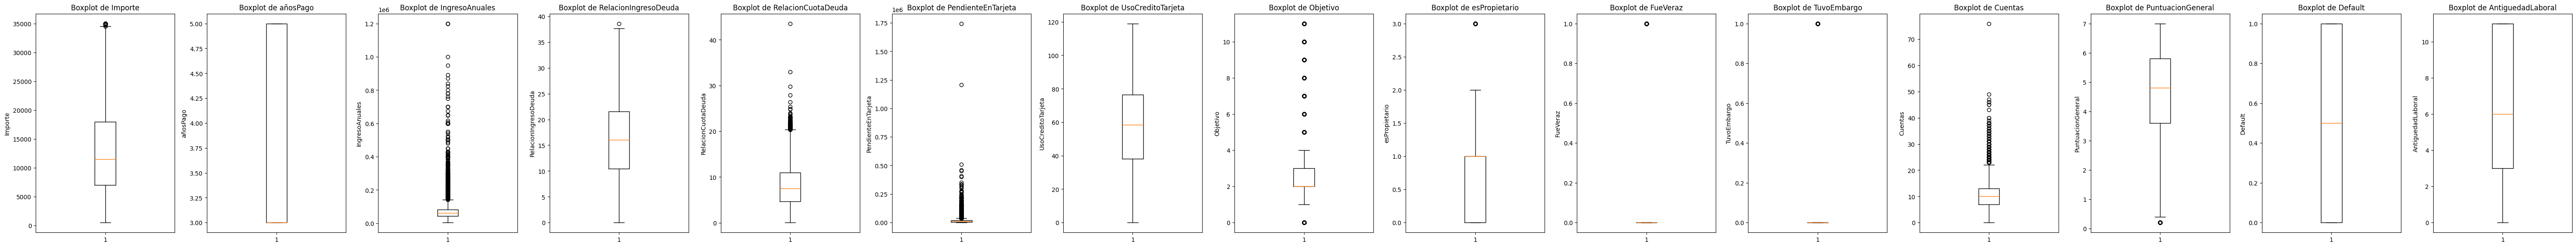

In [118]:
#Obtenemos únicamente las columnas que sean del tipo numéricas
numeric_columns = df.select_dtypes(include=np.number).columns

# Número de columnas numéricas
n = len(numeric_columns)  

# Ajustar el tamaño
plt.figure(figsize=(4 * n, 6))  


for i, column in enumerate(numeric_columns):
    plt.subplot(1, n, i + 1) 
    plt.boxplot(df[column].dropna())  # Evitar NaN en el boxplot 
    plt.title(f'Boxplot de {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

#### Detectamos outliers, por lo que intentamos limpiarlos usando IQR

In [119]:
#Seleccionamos columnas numéricas
df_numeric = df.select_dtypes(include=np.number)

#Elimanos columnas "binarias"

df_numeric.drop(columns=["FueVeraz"], inplace=True)
df_numeric.drop(columns=["TuvoEmbargo"], inplace=True)

#Primer cuartil (Q1)
Q1 = df_numeric.quantile(0.25)  

#Tercer cuartil (Q3)
Q3 = df_numeric.quantile(0.75)  

#Rango intercuartil
IQR = Q3 - Q1  

#Definimos los límites inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Filtramos los datos y actualizamos el dataFrame. "~ Lo utilizamos para tomar los datos que deberiamos eliminar"
mask = ~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)

# Filtrar el DataFrame original usando la máscara y asignarlo de nuevo a df
df = df[mask].reset_index(drop=True)

#Verificamos que se hayan eliminado los outliers
print(df.head())

   Importe  añosPago  IngresoAnuales  RelacionIngresoDeuda  \
0     2000         3           37000                  6.29   
1    28625         5           64000                 15.34   
2    10400         3           76000                 15.11   
3    33425         5           75000                 20.85   
4    15000         5           55000                  7.66   

   RelacionCuotaDeuda  PendienteEnTarjeta  UsoCreditoTarjeta  Objetivo  \
0             2.22551                9663               96.6         2   
1            14.07690               20084               60.3         3   
2             5.71753                4808               40.1         2   
3            14.08580               25807               60.7         2   
4             9.43025                8452               49.4         2   

   esPropietario  FueVeraz  TuvoEmbargo  Cuentas  PuntuacionGeneral  Default  \
0              1         0            0        2                4.4        1   
1              1      

#### Volvemos a ver el Boxplot

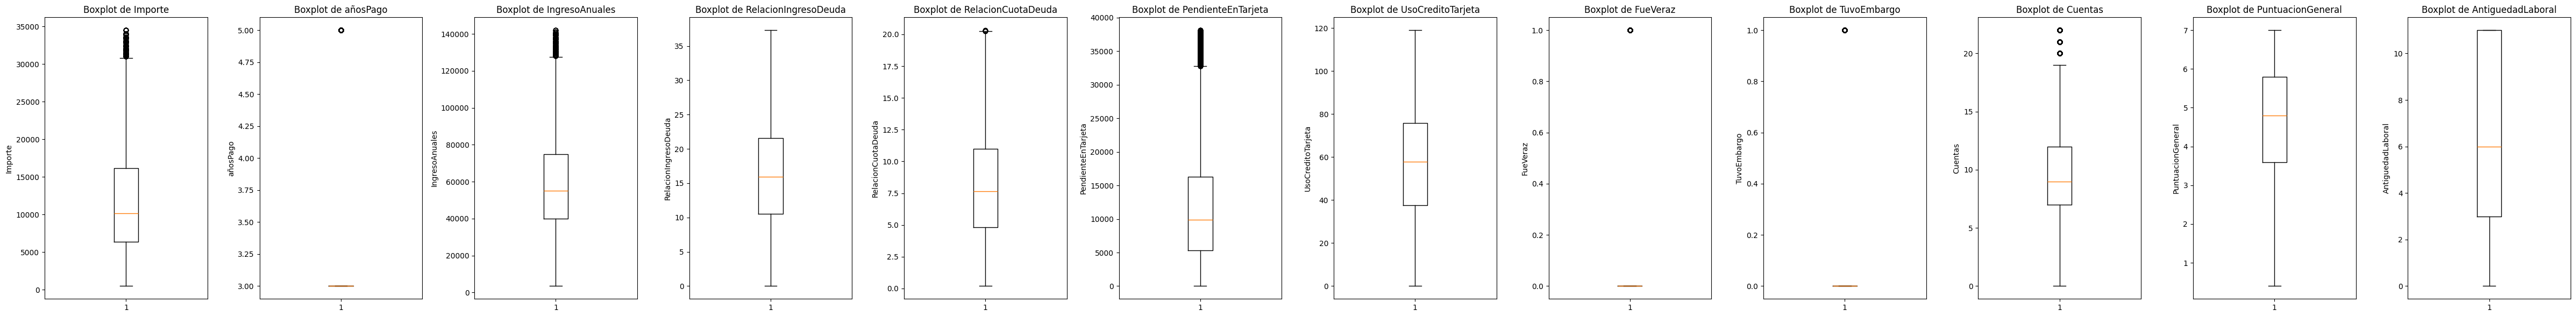

In [48]:
#Obtenemos únicamente las columnas que sean del tipo numéricas
numeric_columns = df.select_dtypes(include=np.number).columns

# Número de columnas numéricas
n = len(numeric_columns)  

# Ajustar el tamaño
plt.figure(figsize=(4 * n, 6))  


for i, column in enumerate(numeric_columns):
    plt.subplot(1, n, i + 1) 
    plt.boxplot(df[column].dropna())  # Evitar NaN en el boxplot 
    plt.title(f'Boxplot de {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()


#### Se visualizan los datos con una distribución más equilibrada

## Balanceo de variable objetivo "Default"

In [120]:
print(df['Default'].unique())

[1 0]


In [121]:
balance_counts = df['Default'].value_counts()

# Mostrar los conteos absolutos
print("Conteos de cada clase:")
print(balance_counts)

balance_proportions = df['Default'].value_counts(normalize=True)
print("\nProporciones de cada clase:")
print(balance_proportions)

Conteos de cada clase:
Default
1    10936
0    10518
Name: count, dtype: int64

Proporciones de cada clase:
Default
1    0.509742
0    0.490258
Name: proportion, dtype: float64


#### Se puede ver que se encuentra balanceada la variable objetivo

#### Realizamos una matriz de correlación para comprender como se relacionan las columnas de df

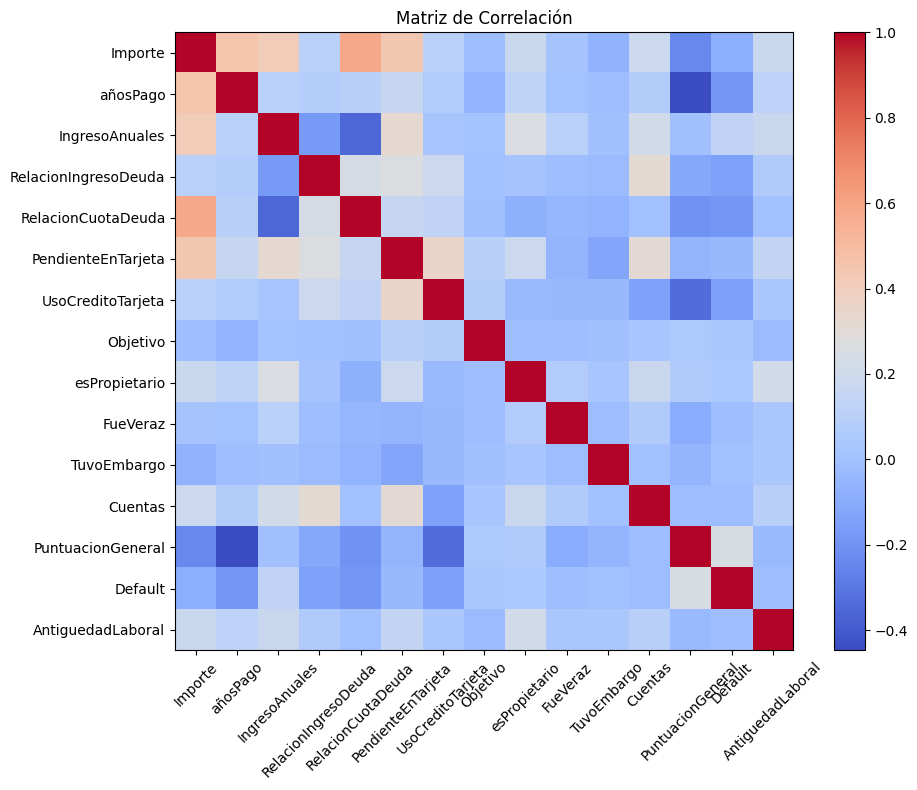

In [122]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

correlation_matrix = df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()



In [ ]:


# numerical_features = ['Age', 'Fare', 'Parch', 'SibSp']
# categorical_features = ['Pclass', 'Sex', 'Embarked']


# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore')) 
# ])